In [2]:
%load_ext autoreload
%autoreload 2

In [21]:
import mscthesis
import geopandas as gpd
import plotly.express as px
import plots
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

In [4]:
tweets = mscthesis.read_geotweets_raw("./../../dbs/sweden/geotweets.csv").set_index(['userid', 'region'])

In [5]:
tweets.groupby(level=0).size().tail(15)

userid
707199518400454656    452
707269946515058688    157
707941888637014016     76
708657310370021382     59
712179199260422144     49
716705607802294274     50
722569311894814720    260
750012578802364416     50
751647827651092481     61
753867220246269952     20
764655612525473792     64
778179816889675777     36
782260642770288640     47
790301765744951296     54
794973407964229636    856
dtype: int64

In [6]:
regions = tweets.groupby(['userid', 'region']).first()[['latitude', 'longitude']]
regions.head(3)

latitude  longitude
userid region                      
5616   0       57.599221  18.436371
       1       59.442985  17.952117
       2       59.652696  17.930374

In [7]:
regions = regions.reset_index(level=1)
regions.head(3)

,region,latitude,longitude
userid,,,
5616,0,57.599221,18.436371
5616,1,59.442985,17.952117
5616,2,59.652696,17.930374


In [8]:
region_groups = mscthesis.cluster_groups(regions).droplevel(0)

In [9]:

region_groups.head(4)

,region,latitude,longitude,group
userid,,,,
5616,0,57.599221,18.436371,0
5616,1,59.442985,17.952117,1
5616,2,59.652696,17.930374,1
5616,4,59.452536,17.930460,1


In [12]:
groups = region_groups.reset_index().set_index(['userid', 'region'])['group']

In [13]:
tweets_x = tweets.join(groups)

In [51]:
user_region_groups = tweets_x.loc[5616].reset_index()

In [52]:
fig = px.scatter_mapbox(user_region_groups, lat='latitude', lon='longitude', hover_data=['group', 'region'], color='group')
fig.update_layout(mapbox_style="open-street-map")
fig.show()

In [14]:
visits = mscthesis.visit_gaps(tweets_x)

In [15]:
group_flow_by_user = visits.groupby(['userid', 'group_origin', 'group_destination']).size()

In [32]:
test = group_flow_by_user.loc[5616].to_frame()
test

0
group_origin group_destination     
0            0                  245
             1                   13
             3                    1
             31                   1
             42                   1
...                             ...
39           40                   1
40           38                   1
41           1                    1
             41                   4
42           1                    1

[127 rows x 1 columns]

In [33]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = list(range(test.index.get_level_values(0).max())),
      color = "blue"
    ),
    link = dict(
      source = test.index.get_level_values(0), # indices correspond to labels, eg A1, A2, A2, B1, ...
      target = test.index.get_level_values(1),
      value = test.values,
  ))])

fig.update_layout(title_text="Basic Sankey Diagram", font_size=10)
fig.show()

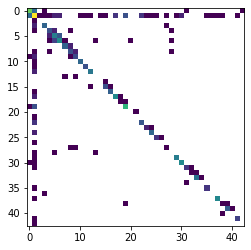

In [36]:
groups_odm = group_flow_by_user.loc[5616].sort_index(level=0).unstack(fill_value=0).sort_index(axis=1)
plt.imshow(
    groups_odm.values,
    norm=mpl.colors.LogNorm(),
)

In [37]:
mat_groups = groups_odm.to_numpy()
mat_groups

array([[ 245,   13,    0, ...,    0,    0,    1],
       [  12, 1313,    1, ...,    0,    1,    0],
       [   0,    1,    0, ...,    0,    0,    0],
       ...,
       [   0,    0,    0, ...,    0,    0,    0],
       [   0,    1,    0, ...,    0,    4,    0],
       [   0,    1,    0, ...,    0,    0,    0]])

In [38]:
mat_groups_x = mat_groups + mat_groups.T - np.diag(np.diag(mat_groups))
mat_groups_x

array([[ 245,   25,    0, ...,    0,    0,    1],
       [  25, 1313,    2, ...,    0,    2,    1],
       [   0,    2,    0, ...,    0,    0,    0],
       ...,
       [   0,    0,    0, ...,    0,    0,    0],
       [   0,    2,    0, ...,    0,    4,    0],
       [   1,    1,    0, ...,    0,    0,    0]])

In [39]:
mat_groups_prob = mat_groups_x / mat_groups_x.sum()
mat_groups_prob

array([[1.07267951e-01, 1.09457093e-02, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 4.37828371e-04],
       [1.09457093e-02, 5.74868651e-01, 8.75656743e-04, ...,
        0.00000000e+00, 8.75656743e-04, 4.37828371e-04],
       [0.00000000e+00, 8.75656743e-04, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 8.75656743e-04, 0.00000000e+00, ...,
        0.00000000e+00, 1.75131349e-03, 0.00000000e+00],
       [4.37828371e-04, 4.37828371e-04, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [46]:
mat_groups_prob.max()

0.5748686514886164